<a href="https://colab.research.google.com/github/KinzaaSheikh/lm_research_notes/blob/main/Hands_On_LLM_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## My Notebook of Hands on LLM book

# Chapter 1

Introduced the recent history of Large Language Models and ended with a small coding example. Its interesting for me to note that a simple query-answer workflow with an LLM is intuitive enough even without using any of the recent frameworks.

In [ ]:
!pip install -Uq transformers

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# Load model and tokenizer
model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3-mini-4k-instruct",
    device_map="cuda",
    torch_dtype="auto",
    trust_remote_code=False,
)
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-4k-instruct")

In [ ]:
from transformers import pipeline

# Create a pipeline
generation = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    return_full_text=False,
    max_new_tokens=500,
    do_sample=False
    )

In [ ]:
# The prompt (user input / query)
messages = [
    {
        "role": "user",
        "content": "Tell me a funny joke about chickens"
    }
]

# Generate output
output = generation(messages)
print(output[0]["generated_text"])

# Chapter 2



### Tokenization & Embeddings

The two main pillars of LLM

Tokenization: The smallest chunk a text can be broken down to.


Embeddings: The act of converting those tokens into computable language

In [ ]:
!pip install -Uq transformers

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# load model and tokenizer just like before
model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3-mini-4k-instruct",
    device_map="cuda",
    torch_dtype="auto",
    trust_remote_code=False,
)
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-4k-instruct")

In [ ]:
prompt = "Write an email to my advisor explaining why I couldn't finish proposal on time. Explain how it happend. <|assistant|>"

# Tokenize the input prompt
input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to("cuda")

# Generate the text
generation_output = model.generate(
    input_ids=input_ids,
    max_new_tokens=20
)

# Print the output
print(tokenizer.decode(generation_output[0]))

In [ ]:
# Print to see what's inside input_ids

print(input_ids)

In [ ]:
# Inspect input ids using tokenizer's decode method
# translate the id's back into human readable text

for id in input_ids[0]:
  print(tokenizer.decode(id))

In [ ]:
print(generation_output)

In [ ]:
# we can decode the tokenizer on the output side to translate the token id in actual text
print(tokenizer.decode(8496))
print(tokenizer.decode(29915))
print(tokenizer.decode(29873))

In [ ]:
print(tokenizer.decode([8496, 29915, 29873]))

In [ ]:
# Generate contextualized word embeddings

from transformers import AutoModel, AutoTokenizer

# Load a tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-base")

# Load a language model
model = AutoModel.from_pretrained("microsoft/deberta-v3-xsmall")

# Tokenize the sentence
tokens = tokenizer('Hello World', return_tensors='pt')

# Process the toekns
output = model(**tokens)[0]

In [ ]:
output.shape

In [ ]:
# Inspect why there are four tokens in two words

for token in tokens['input_ids'][0]:
  print(tokenizer.decode(token))

In [ ]:
print(output)

In [ ]:
# Text embeddings
from sentence_transformers import SentenceTransformer

# Load model
model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")

# Convert text to text embeddings
vector = model.encode("Best movie ever!")

In [ ]:
vector.shape

### Word embeddings beyond LLMs


NOTE: Gensim causes a lot of dependency errors so its best to kill the runtime and start over from here

In [ ]:
!pip -q install gensim

In [ ]:
# Download embeddings (66MB, glove, trained on wikipedia, vector size: 50)
# Other options include "word2vec-google-news-300"
# More options at https://github.com/RaRe-Technologies/gensim-data
# Installing specific versions to avoid conflicts
import gensim.downloader as api
model = api.load("glove-wiki-gigaword-50")

In [ ]:
model.most_similar([model['king']], topn=11)

### Training a song embedding model

In [ ]:
import pandas as pd
from urllib import request

# Get the playlist dataset file
data = request.urlopen("https://storage.googleapis.com/maps-premium/dataset/yes_complete/train.txt")

# Parse the playlist dataset file. Skip the first to lines as
# they only contian metadata
lines = data.read().decode("utf-8").split('\n')[2:]

# Remove playlists with only song
playlists = [s.rstrip().split() for s in lines if len(s.split()) > 1]

# Load song metadata
songs_file = request.urlopen('https://storage.googleapis.com/maps-premium/dataset/yes_complete/song_hash.txt')
songs_file = songs_file.read().decode('utf-8').split('\n')
songs = [s.rstrip().split('\t') for s in songs_file]
songs_df = pd.DataFrame(data=songs, columns = ['id', 'title', 'artist'])
songs_df = songs_df.set_index('id')

In [ ]:
print('Playlist #1:/n', playlists[0]), '\n'

In [ ]:
# Train the model
from gensim.models import Word2Vec

# Train our Word2Vec model
model = Word2Vec(
    playlists,
    vector_size=32,
    window=20,
    negative=50,
    min_count=1,
    workers=4
)

In [ ]:
song_id = 2172

# Ask the model for songs similar to song number 2172
model.wv.most_similar(positive=str(song_id))

In [ ]:
print(songs_df.iloc[2173])

In [ ]:
# Results are all heavy metal and hard rock, within the same genre
import numpy as np

def print_recommendations(song_id):
  similar_songs = np.array(
      model.wv.most_similar(positive=str(song_id), topn=5)
  )[:,0]

  return songs_df.iloc[similar_songs]

# Extract recommendations
print_recommendations(2172)

# Chapter 3

NOTE: Rerun the first 3 cells of the notebook


In [ ]:
prompt = "Write an email apologizing to Sarah for the tragic gardening mishap. Explain how it happened."

output = generation(prompt)

print(output[0]['generated_text'])

In [ ]:
# Display order of layers

print(model)

In [ ]:
prompt = "The capital of France is"

# Tokenize the input prompt
input_ids = tokenizer(prompt, return_tensors="pt").input_ids
input_ids = input_ids.to("cuda")

# Get the output of the model before the lm_head
model_output = model.model(input_ids)

# Get the output of the lm_head
lm_head_output = model.lm_head(model_output[0])

In [ ]:
print(model_output)

In [ ]:
print(lm_head_output)

In [ ]:
token_id = lm_head_output[0, -1].argmax(-1)
tokenizer.decode(token_id)

In [ ]:
model_output[0].shape

In [ ]:
lm_head_output[0].shape

In [ ]:
# Testing speed by disabling built-in caching

prompt = "write a very long email apologizing to Sarah for the tragic gardening mishap. Explain how it happened."

input_ids = tokenizer(prompt, return_tensors="pt").input_ids
input_ids= input_ids.to("cuda")


In [ ]:
# Generate 100 tokens with caching and time it

%%timeit -n 1
generation_output = model.generate(
    input_ids=input_ids,
    max_new_tokens=100,
    use_cache=True
)

In [ ]:
# Generate the same amount of tokens with caching disabled

%%timeit -n 1
generation_output = model.generate(
    input_ids=input_ids,
    max_new_tokens=100,
    use_cache=False
)

# Chapter 4


In [ ]:
!pip install -q datasets transformers numpy tqdm scikit-learn

In [ ]:
from datasets import load_dataset

data = load_dataset("rotten_tomatoes")
data

In [ ]:
data["train"][0, -1]

# Classification of reviews are binary, either 0 (negative) or 1 (positive)

In [ ]:
data["test"][0, -1]

In [ ]:
from transformers import pipeline

# Path to our HF model
model_path = "cardiffnlp/twitter-roberta-base-sentiment-latest"

# Load the mmodel into pipeline
pipe = pipeline(
    model=model_path,
    tokenizer=model_path,
    return_all_scores=True,
    device="cuda:0"
)

In [ ]:
import numpy as np
from tqdm import tqdm
from transformers.pipelines.pt_utils import KeyDataset

# Run inference
y_pred = []
for output in tqdm(pipe(KeyDataset(data["test"], "text")),
                  total=len(data["test"])):
  negative_score = output[0]["score"]
  positive_score = output[2]["score"]
  assignment = np.argmax([negative_score, positive_score])
  y_pred.append(assignment)

In [ ]:
# After generating predictions its time to evals

from sklearn.metrics import classification_report

def evaluate_performance(y_true, y_pred):
  """Create and print the classification report"""
  performance = classification_report(
      y_true,
      y_pred,
      target_names=["Negative Review", "Positive Review"]
  )
  print(performance)

In [ ]:
# Create classification report
evaluate_performance(data["test"]["label"], y_pred)

# Chapter 5


In [6]:
!pip install -qU umap

In [1]:
# clustering and topic modeling algorithms onn ArXiv articles

# Load data from Hugging Face
from datasets import load_dataset
dataset = load_dataset("maartengr/arxiv_nlp")["train"]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/617 [00:00<?, ?B/s]

data.csv:   0%|          | 0.00/53.2M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [2]:
# Extract metadata
abstracts = dataset["Abstracts"]
titles = dataset["Titles"]

## Embedding Documents

In [3]:
from sentence_transformers import SentenceTransformer

# Create an embedding for each abstract
embedding_model = SentenceTransformer("thenlper/gte-small")
embeddings = embedding_model.encode(abstracts, show_progress_bar=True)

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1405 [00:00<?, ?it/s]

In [4]:
# Check the dimensions of the resulting embeddings
embeddings.shape

(44949, 384)

## Dimensionality Reduction

In [8]:
# We reduce the input embeddings from 384 dimensions to 5 dimensions

from umap.umap_ import UMAP

umap_model = UMAP(
    n_components = 5,
    min_dist = 0.0,
    metric = "cosine",
    random_state = 42
)

reduced_embeddings = umap_model.fit_transform(embeddings)

# setting random_state in umap will make the results reproducible across sessions but will disable parallelism and that will slow down training time

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


## Cluster the Reduced Embeddings

In [9]:
from hdbscan import HDBSCAN

# Fit the model and extract the clusters
hdbscan_model = HDBSCAN(
    min_cluster_size = 50,
    metric = "euclidean",
    cluster_selection_method = "eom"
).fit(reduced_embeddings)

clusters = hdbscan_model.labels_

# Check how many clusters were generated
len(set(clusters))

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


155

In [11]:
# inspect the clusters

import numpy as np

# print first three documents in cluster 0
cluster = 0
for index in np.where(clusters==cluster)[0][:3]:
  print(abstracts[int(index)][:300] + "... \n")

  This works aims to design a statistical machine translation from English text
to American Sign Language (ASL). The system is based on Moses tool with some
modifications and the results are synthesized through a 3D avatar for
interpretation. First, we translate the input text to gloss, a written fo... 

  Researches on signed languages still strongly dissociate lin- guistic issues
related on phonological and phonetic aspects, and gesture studies for
recognition and synthesis purposes. This paper focuses on the imbrication of
motion and meaning for the analysis, synthesis and evaluation of sign lang... 

  Modern computational linguistic software cannot produce important aspects of
sign language translation. Using some researches we deduce that the majority of
automatic sign language translation systems ignore many aspects when they
generate animation; therefore the interpretation lost the truth inf... 



In [12]:
# visualize the clusters

import pandas as pd

# reduce 384-dimensional embeddings to two dimensions for easier visualization
reduced_embeddings = UMAP(
    n_components = 2,
    min_dist = 0.0,
    metric = "cosine",
    random_state = 42
).fit_transform(embeddings)

# create dataframe
df = pd.DataFrame(
    reduced_embeddings,
    columns=["x", "y"]
)
df["title"] = titles
df["cluster"] = [str(c) for c in clusters]

# select outlier and non-outlier clusters
to_plot = df.loc[df.cluster != "-1", :]
outliers = df.loc[df.cluster == "-1", :]

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


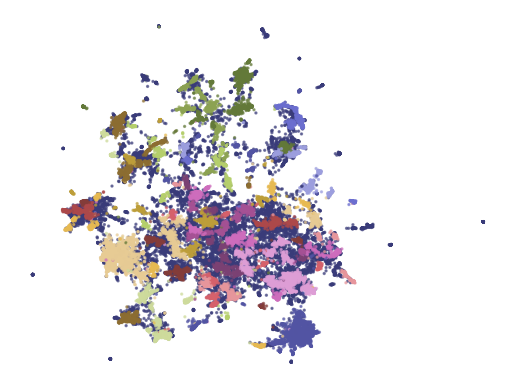

In [14]:
import matplotlib.pyplot as plt

# plot outliers and non-outliers separately
plt.scatter(
    outliers.x,
    outliers.y,
    c = outliers.cluster.astype(int),
    alpha = 0.6,
    s = 2,
    cmap = 'tab20b'
)

plt.scatter(
    to_plot.x,
    to_plot.y,
    c = to_plot.cluster.astype(int),
    alpha = 0.6,
    s = 2,
    cmap = 'tab20b'
)

plt.axis("off")
plt.show()

In [ ]:
# Text clustering to topic modelling

